<a href="https://colab.research.google.com/github/salilp42/salilp42.github.io/blob/master/Saccade_Upload_%2B_NMTools_mount.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import os
os.getcwd()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os

project_path = '/content/drive/My Drive/jupyter-1.0.0'
os.chdir(project_path)

In [9]:
import nmtools
import numpy as np

In [10]:
from nmtools.oxquip import SaccadeProtocol
p=SaccadeProtocol.load_from_directory("./")
protocol = list(p)[:]
protocol

[SaccadeProtocol<Participant 50011, 101 saccades>,
 SaccadeProtocol<Participant 50004, 201 saccades>,
 SaccadeProtocol<Participant 50008, 95 saccades>,
 SaccadeProtocol<Participant 50005, 206 saccades>,
 SaccadeProtocol<Participant 50012, 78 saccades>,
 SaccadeProtocol<Participant 50009, 219 saccades>,
 SaccadeProtocol<Participant 50006>,
 SaccadeProtocol<Participant 50007, 6 saccades>,
 SaccadeProtocol<Participant 50014>,
 SaccadeProtocol<Participant 50001, 196 saccades>]

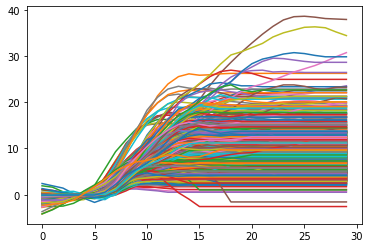

In [46]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

n_dim = 30

traces = np.vstack([
    protocol.extract_samples(30)
    for protocol in p
    if protocol.samples is not None
])

plt.plot(traces.transpose());

In [47]:
def generate_real_samples(n):
    '''generate n real samples with class labels'''
    x1 = np.tile(np.arange(0,30),(n,1))
    x2 = traces[np.random.randint(traces.shape[0], size=n),:]        #generate outputs
    y = np.ones((n, 1))     #generate class label
    return x2,y

generate_real_samples(3)

#Add convolutional neural net layer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU, Conv1D, Flatten, Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dropout, LSTM


def define_generator(latent_dim=100):
    model = Sequential()
    model.add(LSTM(256, input_shape=(latent_dim, 1), return_sequences=True))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.4))
    model.add(LSTM(256, return_sequences=True))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.4))
    model.add(Dense(n_dim))
    model.add(Activation('sigmoid'))
    return model

    generator_model.summary()
plot_model(generator_model, to_file = 'generator_model.png', show_shapes = True)

# Discriminator
def define_discriminator(inputs = n_dim):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, strides=1, padding='same', input_shape=(n_dim,1)))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Conv1D(64, kernel_size=3, strides=1, padding='same'))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Conv1D(64, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Conv1D(128, kernel_size=3, strides=1, padding='same'))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Conv1D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

discriminator_model = define_discriminator()
discriminator.summary()
plot_model(discriminator, to_file = 'discriminator_model.png', show_shapes = True)

gan_model = define_gan(generator_model, discriminator_model)


def generate_latent_points(latent_dim, n):
    '''generate points in latent space as input for the generator'''
    x_input = np.random.rand(latent_dim * n) #generate points in latent space
    x_input = x_input.reshape((n, latent_dim))  #reshape
    return x_input

#generate and save an image of generated samples

def generate_fake_samples(generator, latent_dim, n):
    x_input = generate_latent_points(latent_dim, n)
    X = generator.predict(x_input)
    y = np.zeros((n, 1))
    return X, y

#define a composite model for training the generator and discriminator together

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

def define_gan(generator, discriminator):
    #make weights in the discriminator not trainable
    discriminator.trainable = False
    #connect them
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    #compile model
    opt = Adam(lr = 0.0002, beta_1 = 0.5)
    model.compile(loss = 'binary_crossentropy', optimizer = opt)
    return model

#evaluate the performance of the generator

def summarize_performance(i, g_model, latent_dim, n=100):
    X_real, y_real = generate_real_samples(n)
    _, acc_real = discriminator.evaluate(X_real, y_real, verbose = 0)
    X_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    _, acc_fake = discriminator.evaluate(X_fake, y_fake, verbose = 0)
    print(epoch, acc_real, acc_fake)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 30, 32)            128       
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 30, 32)            0         
                                                                 
 conv1d_11 (Conv1D)          (None, 30, 64)            6208      
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 30, 64)            0         
                                                                 
 flatten_5 (Flatten)         (None, 1920)              0         
                                                                 
 dense_12 (Dense)            (None, 25)                48025     
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 25)               

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [48]:
#train the generator and discriminator

def train_gan(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=256):
    bat_per_epo = int(traces.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            #get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(half_batch)
            X_real = np.expand_dims(X_real, axis=2)
            #update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            #generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            X_fake = np.expand_dims(X_fake, axis=2)
            #update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            #prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            #create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            #update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            #summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        #evaluate the model performance, sometimes
        if (i+1) % 100 == 0:
            summarize_performance(i, g_model, latent_dim)


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


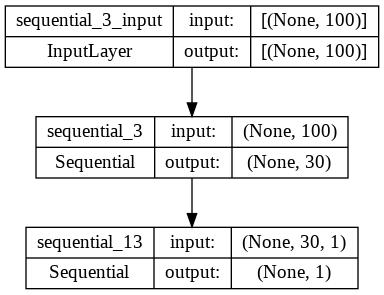

In [52]:
#depict GAN model in entirity 

from tensorflow.keras.utils import plot_model

# Define the GAN model
gan_model = define_gan(generator_model, discriminator_model)

# Visualize the GAN model
plot_model(gan_model, to_file='gan_model.png', show_shapes=True, show_layer_names=True)


In [49]:
def summarize_performance(epoch, generator, latent_dim, n=100):
    X_real, y_real = generate_real_samples(n)
    _, acc_real = discriminator.evaluate(X_real, y_real, verbose = 0)
    X_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    _, acc_fake = discriminator.evaluate(X_fake, y_fake, verbose = 0)
    print(epoch, acc_real, acc_fake)

In [50]:
train_gan(generator_model, discriminator_model, gan_model, latent_dim, n_epochs = 10000)

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 4ms/step
>9377, 4/4, d1=0.370, d2=0.318 g=1.417
4/4 [==============================] - 0s 3ms/step
>9378, 1/4, d1=0.272, d2=0.289 g=1.450
4/4 [==============================] - 0s 7ms/step
>9378, 2/4, d1=0.124, d2=0.284 g=1.490
4/4 [==============================] - 0s 4ms/step
>9378, 3/4, d1=0.091, d2=0.295 g=1.481
4/4 [==============================] - 0s 3ms/step
>9378, 4/4, d1=0.047, d2=0.507 g=1.412
4/4 [==============================] - 0s 3ms/step
>9379, 1/4, d1=0.056, d2=1.682 g=1.654
4/4 [==============================] - 0s 6ms/step
>9379, 2/4, d1=0.190, d2=0.181 g=2.131
4/4 [==============================] - 0s 6ms/step
>9379, 3/4, d1=0.996, d2=0.161 g=1.981
4/4 [==============================] - 0s 4ms/step
>9379, 4/4, d1=1.114, d2=0.416 g=1.883
4/4 [==============================] - 0s 4ms/step
>9380, 1/4, d1=0.939, d2=0.447 g=1.894
4/4 [==============================] - 0s 5ms/ste

2/2 [==============================] - 0s 6ms/step


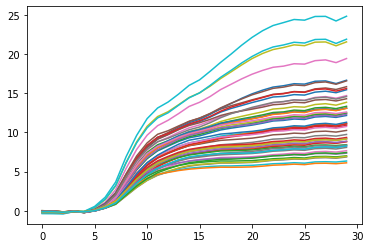

In [51]:
(points, _) = generate_fake_samples(generator_model, latent_dim, 50)

plt.plot(points.transpose());